# Homework #4 Part I: Fit this model using HMC in `PyMC`

For the model specification example considered in "Metropolis within Gibbs" above...


## Provide posterior analysis for this model using "default" `PyMC` 

- Don't try to do "Metropolis within Gibbs" `in PyMC` -- you can't -- use the default HMC sampler
- You can do this without knowing what HMC is: you've already previously used HMC with `PyMC`; and, you can go get the distributions you need [here...](https://www.pymc.io/projects/docs/en/stable/api/distributions.html)
- ***Explore and describe the sample sizes needed to support inference regarding the `df` parameter $(\nu)$***


In [55]:
import pymc as pm
import scipy.stats as stats
import arviz as az

# copied from before
mu_0,sigma_0=0,10
loc_prior = stats.norm(loc=mu_0, scale=sigma_0) # mean=mu_0 / std=sigma_0
scale_prior = stats.halfnorm(scale=5) # std=1
df_prior = stats.randint(low=1, high=101) # df ~ Unif{1, 2, ..., 100}

n,loc_true,scale_true,df_true = 30000,10,2,15 # True values data will be from... IRL, we don't know these values
x = stats.t(df=df_true, loc=loc_true, scale=scale_true).rvs(n) # Data from location-scale-t distribution


m = pm.Model()
with m:
    loc = pm.Normal('loc',mu=mu_0,sigma=sigma_0)
    scale = pm.HalfNormal('scale',sigma=5)
    df = pm.DiscreteUniform('df',lower=1,upper=100)
    x_obs = pm.StudentT('x_obs',nu=df,mu=loc,sigma=scale,observed=x)
    trace = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [loc, scale]
>Metropolis: [df]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'loc'}>, <Axes: title={'center': 'loc'}>],
       [<Axes: title={'center': 'df'}>, <Axes: title={'center': 'df'}>],
       [<Axes: title={'center': 'scale'}>,
        <Axes: title={'center': 'scale'}>]], dtype=object)

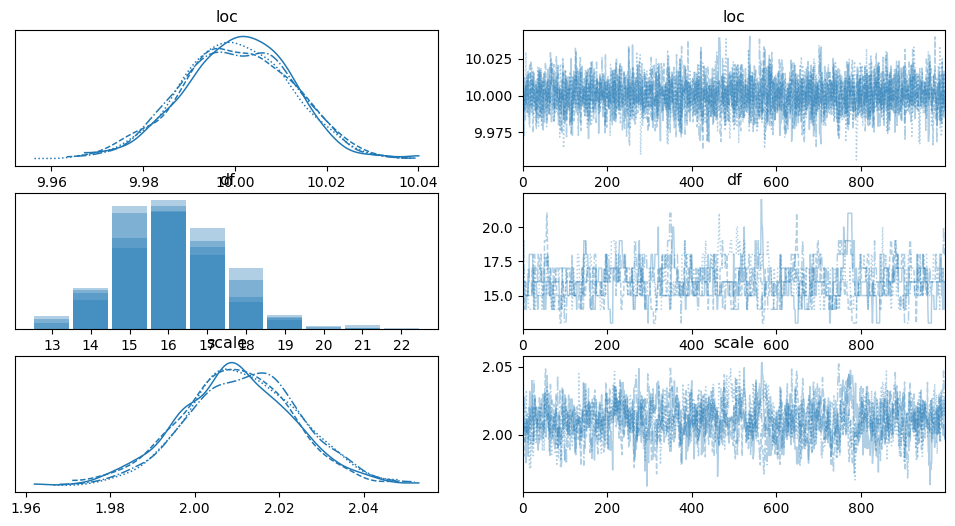

In [56]:
az.plot_trace(trace)

For a good inference of df, we need a sample size of at least 5000 but there are still issues with rhat and effective sample size.
The issues with rhat disappear at 10000 samples and but the issues with effective sample size stay until over 30000.
At 100, 200, 5000 and 1000 the distribution of df is not focused at all around 15. At 2000, it starts to focus around 15 but is still broad.

# Homework #4 Part II: HMC Diagnostics 

- Return to your posterior analysis in "Homework #4 Part I" and 
report on (a) ***effective sample sizes***; (b) ***chain convergence measures***; (c) ***divergences***; (d) ***Metropolis-Hastings acceptance rates*** [see below for how to access these]; and (e) any other warnings or concers provided by `PyMC` 

- Now examine the [Eight Schools](https://github.com/pointOfive/STA410_W24_StatisticalComputation/blob/main/Week3/STA410_W24_Week3_Demo_HMCwithPyMC.ipynb) example PyMC model and outputted results
    - Provide an analogous report regarding (a)-(e) above for the "centered" and "uncentered" Eight Schools models
        - *Hint: for (d) see `fit_C.sample_stats.acceptance_rate.values.flatten()` and `fit_NC.sample_stats.acceptance_rate.values.flatten()` and in the Eight Schools example* 
    - From the perspective of ***curvature*** of the ***energy function*** (that is, how rapidly the ***log joint posterior distribution density*** changes for different values of its ***random variable (parameters)*** and the effectiveness of the ***HMC*** algorithm, explain why the "uncentered" paramterization of the model performs better than the "centered" parameterization
        - *Hint: see the previous two slides...*
- Review [this](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html#model-checking) and [that](https://discourse.pymc.io/t/about-nuts-sampling-and-energy-plot/831) discussing the ***diagnostic plot*** which compares the ***observed energy proposal distribution*** versus the ***empirical energy distribution*** of the generated HMC samples
    - Use the code on the next slide to provide and interpret the ***diagnostic plot*** assessing ***energy proposals*** versus the empirical ***energy*** distribution to compare and contrast the "centered" and "uncentered" Eight Schools models in relation to you previous comparision of these two model parameterization in terms of ***energy function curvature*** and the effectiveness of the ***HMC*** algorithm... does this diagnostic support your previous conclusions in these regards?




In [34]:
az.summary(trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
loc,10.03,0.03,9.98,10.09,0.00,0.0,2692.07,2363.86,1.00
df,17.46,4.25,11.00,24.00,0.28,0.2,269.45,325.08,1.02
scale,2.00,0.03,1.93,2.06,0.00,0.0,464.24,630.99,1.01


The effective samples sizes are 2364 for loc, 270 for df and 464 for scale. This highlights how difficult to sample from the distribution of df. 

The r_hat is the split-rhat value and is very close to 1, which is good.

In [37]:
trace.sample_stats["diverging"].sum()

<xarray.DataArray 'diverging' ()>
array(0)

There were no chains which diverged

Text(0.5, 1.0, 'Acceptance Rates')

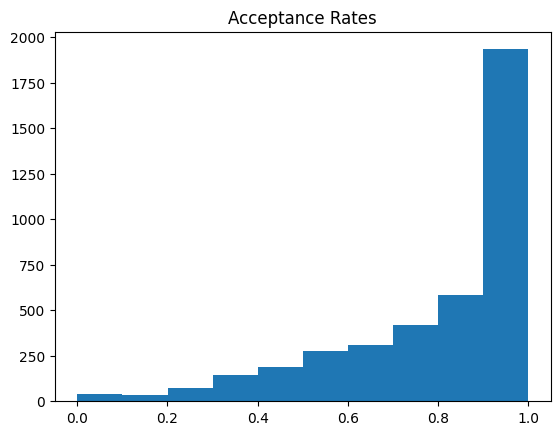

In [38]:
import matplotlib.pyplot as plt
plt.hist(trace.sample_stats.acceptance_rate.values.flatten())
plt.title('Acceptance Rates')

The model generally has high acceptance rates, which is good.

## Eight Schools Model

In [40]:
import numpy as np
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

with pm.Model() as Centered_eight:

    # We assume the following prior distributions for our parameters
    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)

    # and we assume the following probabilistic hierarchy
    # within the data generating mechanism
    theta = pm.Normal("theta", mu=mu, sigma=tau, shape=J) # theta is length J=8

    # Note that if tau was small, then the density evalution above
    # could change rapidly for changes in theta
    # This means that the energy has high curvature

    # likelihood where observed information enters into the model
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)
     
SEED = [20100420, 20134234] # random seeds for each of two run HMC chains
with Centered_eight:
    fit_C = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                      return_inferencedata=True, idata_kwargs={"log_likelihood": True})

with pm.Model() as NonCentered_eight:

    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta_tilde = pm.Normal("theta_t", mu=0, sigma=1, shape=J)
    # Changes in theta now take place on a fixed scale that is independent of tau

    theta = pm.Deterministic("theta", mu + tau * theta_tilde)
    # Changes in tau can still result in rapid changes in the density evaluations
    # below so the energy still has high curvature with respect to tau; but,
    # it no longer has high curvature with respect to theta
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)
    fit_NC = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                       return_inferencedata=True, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, tau, theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 25 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, tau, theta_t]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 21 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [44]:
az.summary(fit_C, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,4.29,3.27,-1.75,10.13,0.20,0.14,282.27,1635.91,1.01
theta[0],6.39,5.80,-4.01,17.63,0.18,0.13,488.35,2611.17,1.01
theta[1],4.97,4.81,-4.07,13.81,0.20,0.14,499.77,2969.30,1.01
theta[2],3.70,5.46,-6.95,14.06,0.14,0.10,905.61,3422.01,1.00
theta[3],4.76,4.94,-4.25,14.61,0.15,0.11,793.44,3934.10,1.00
theta[4],3.36,4.79,-6.17,11.94,0.21,0.15,436.28,3329.88,1.01
theta[5],3.89,4.99,-5.84,13.03,0.18,0.13,614.95,3571.06,1.00
theta[6],6.50,5.22,-2.85,16.29,0.22,0.16,421.82,1854.08,1.01
theta[7],4.79,5.51,-5.77,15.20,0.20,0.14,566.50,3713.88,1.00
tau,4.05,3.17,0.79,9.68,0.21,0.15,67.64,34.67,1.04


In [46]:
az.summary(fit_NC, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,4.40,3.30,-1.71,10.69,0.03,0.02,11120.12,6319.82,1.0
theta_t[0],0.33,1.00,-1.52,2.25,0.01,0.01,12332.60,6677.65,1.0
theta_t[1],0.11,0.93,-1.66,1.83,0.01,0.01,13263.21,7097.14,1.0
theta_t[2],-0.08,0.98,-1.97,1.70,0.01,0.01,15199.46,6188.73,1.0
theta_t[3],0.07,0.93,-1.72,1.83,0.01,0.01,14951.30,7291.90,1.0
theta_t[4],-0.15,0.92,-1.87,1.62,0.01,0.01,14707.69,7426.50,1.0
theta_t[5],-0.08,0.94,-1.78,1.75,0.01,0.01,13359.94,7108.87,1.0
theta_t[6],0.35,0.95,-1.43,2.15,0.01,0.01,11562.53,7108.09,1.0
theta_t[7],0.07,0.99,-1.78,1.91,0.01,0.01,15762.83,6727.60,1.0
tau,3.58,3.20,0.00,9.18,0.04,0.03,5121.40,3807.87,1.0


The non-centered model has a higher effective sample size and lower r_hat value for all parameters.

In [48]:
print(fit_C.sample_stats["diverging"].sum())
print(fit_NC.sample_stats["diverging"].sum())


<xarray.DataArray 'diverging' ()>
array(328)
<xarray.DataArray 'diverging' ()>
array(8)


The non-centered model barely diverges while the centered model diverges.

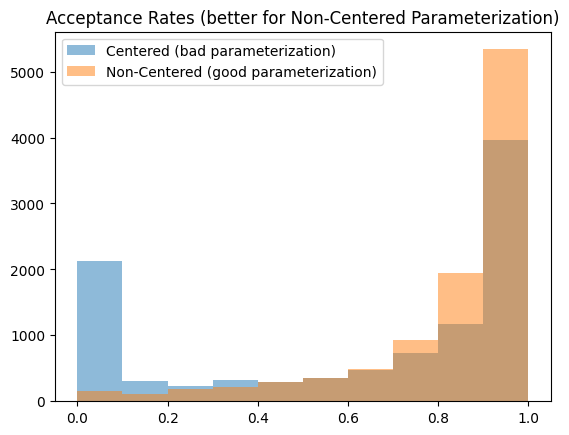

In [49]:
plt.hist(fit_C.sample_stats.acceptance_rate.values.flatten(), alpha=0.5,
         label='Centered (bad parameterization)');
plt.hist(fit_NC.sample_stats.acceptance_rate.values.flatten(), alpha=0.5,
         label='Non-Centered (good parameterization)');
plt.title('Acceptance Rates (better for Non-Centered Parameterization)'); plt.legend();

From the perspective of ***curvature*** of the ***energy function*** (that is, how rapidly the ***log joint posterior distribution density*** changes for different values of its ***random variable (parameters)*** and the effectiveness of the ***HMC*** algorithm, explain why the "uncentered" paramterization of the model performs better than the "centered" parameterization.

The uncentered model performs better than the centered model because the centered model has a higher curvature of the energy function which results in quick changes in the log joing posterior energy distribution. This is because in the centered model small values for tau can have a large influence on theta, causing strong correlation between parameters, which makes the energy function more curved. The uncentered model has a lower correlation between the parameters, which makes the energy function less curved.

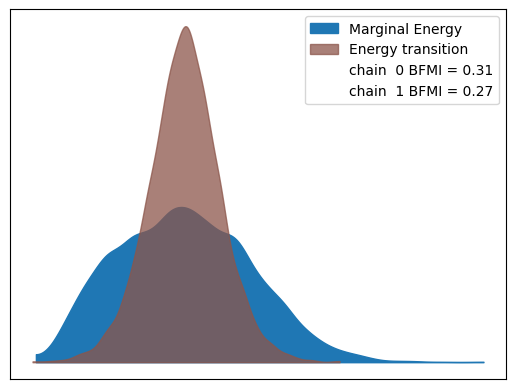

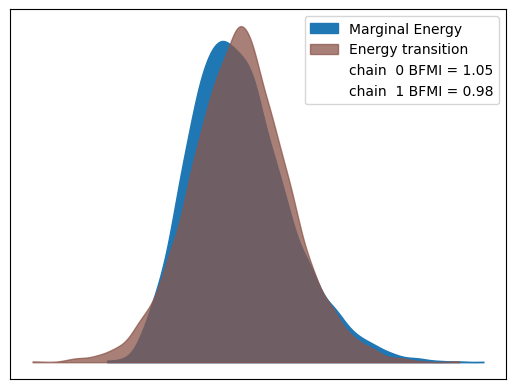

In [50]:
az.plot_energy(fit_C)
az.plot_energy(fit_NC)

In the centered model, there is a large difference between the observed energy proposal distribution and the empirical energy distribution of the generated HMC samples. This is not the case for the uncentered model. This difference means that in the centered model, that the energy is not sufficient to explore the entire mass of the distribution. 